In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/formula-1-championships-1950-2025/races.csv
/kaggle/input/formula-1-championships-1950-2025/drivers.csv
/kaggle/input/formula-1-championships-1950-2025/constructors.csv
/kaggle/input/formula-1-championships-1950-2025/driver_standings.csv
/kaggle/input/formula-1-championships-1950-2025/constructor_standings.csv
/kaggle/input/formula-1-championships-1950-2025/results.csv
/kaggle/input/formula-1-championships-1950-2025/circuits.csv
/kaggle/input/formula-1-championships-1950-2025/qualifying.csv


In [18]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder # <-- Yeni Mühendislik Aracımız

# --- ADIM 1: VERİ YÜKLEME ---
base_path = '/kaggle/input/formula-1-championships-1950-2025/'
races = pd.read_csv(base_path + 'races.csv')
results = pd.read_csv(base_path + 'results.csv')

# --- ADIM 2: VERİ BİRLEŞTİRME ---
# races tablosundan race_id ve season alıyoruz
df = pd.merge(results, races[['race_id', 'season']], on='race_id', how='left')

# --- ADIM 3: FİLTRELEME VE SEÇİM ---
df = df[df['season'] >= 2010]

# Sütunları seçiyoruz
cols_to_keep = ['grid', 'constructor_id', 'points', 'season', 'position_order']
final_df = df[cols_to_keep].copy()

# --- ADIM 4: METİN VERİSİNİ SAYIYA ÇEVİRME (LABEL ENCODING) ---
# Mühendislik Müdahalesi: "Ferrari" -> 1 dönüşümü
print("Dönüşüm öncesi veri tipleri:")
print(final_df.dtypes)

# Otomatik olarak 'object' (yazı) olan sütunları bulup sayıya çevirelim
label_encoders = {}
for col in final_df.columns:
    if final_df[col].dtype == 'object':
        print(f"--> '{col}' sütunu sayıya çevriliyor...")
        le = LabelEncoder()
        # Yazıları sayıya çevirip üzerine yazıyoruz
        final_df[col] = le.fit_transform(final_df[col].astype(str))
        label_encoders[col] = le # Kodları saklıyoruz (İleride geri çevirmek istersek diye)

# --- ADIM 5: EKSİK VERİ DOLDURMA (KNN) ---
# 1. Hedef değişkeni boş olanları at
final_df = final_df.dropna(subset=['position_order'])

# 2. KNN ile doldur (Artık her şey sayı olduğu için hata vermeyecek)
imputer = KNNImputer(n_neighbors=5)
final_array = imputer.fit_transform(final_df)

# DataFrame'e geri çevir
final_df_imputed = pd.DataFrame(final_array, columns=final_df.columns)

print("\n--- İŞLEM BAŞARILI ---")
print("Tüm veriler sayısallaştırıldı ve eksikler tamamlandı.")
print("Veriden ilk 5 satır (Artık her şey sayı):")
display(final_df_imputed.head())

Dönüşüm öncesi veri tipleri:
grid                int64
constructor_id     object
points            float64
season              int64
position_order      int64
dtype: object
--> 'constructor_id' sütunu sayıya çevriliyor...

--- İŞLEM BAŞARILI ---
Tüm veriler sayısallaştırıldı ve eksikler tamamlandı.
Veriden ilk 5 satır (Artık her şey sayı):


,grid,constructor_id,points,season,position_order
0,3.0,5.0,25.0,2010.0,1.0
1,2.0,5.0,18.0,2010.0,2.0
2,4.0,13.0,15.0,2010.0,3.0
3,1.0,17.0,12.0,2010.0,4.0
4,5.0,14.0,10.0,2010.0,5.0


In [19]:
import torch
from sklearn.model_selection import train_test_split

# 1. Girdi (X) ve Hedef (y) Ayrımı
# X: Neye bakacağız? (Grid, Takım, Puan, Yıl)
# y: Neyi tahmin edeceğiz? (Bitiş Sırası - position_order)

X = final_df_imputed.drop('position_order', axis=1).values # .values diyerek numpy array'e çeviriyoruz
y = final_df_imputed['position_order'].values

# 2. Eğitim ve Test Olarak Bölme (%80 Eğitim, %20 Test)
# random_state=42 mühendislikte bir gelenektir (Otostopçunun Galaksi Rehberi referansı),
# her çalıştırdığında aynı rastgelelikle bölmesini sağlar.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. PyTorch Tensörüne Çevirme
# PyTorch genelde Float32 ile çalışır (Ondalıklı sayı hassasiyeti)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Hedef değişkeni (y) sütun vektörü haline getiriyoruz (reshape)
# Yani [1, 2, 3] değil, [[1], [2], [3]] olsun istiyoruz. PyTorch bunu sever.
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print("--- MÜHENDİSLİK KONTROLÜ ---")
print(f"Eğitim Verisi Şekli (X_train): {X_train.shape}")
print(f"Eğitim Hedefi Şekli (y_train): {y_train.shape}")
print(f"Test Verisi Şekli   (X_test):  {X_test.shape}")
print("\nÖrnek bir Tensör verisi:")
print(X_train[0]) # İlk satırı görelim

--- MÜHENDİSLİK KONTROLÜ ---
Eğitim Verisi Şekli (X_train): torch.Size([1280, 4])
Eğitim Hedefi Şekli (y_train): torch.Size([1280, 1])
Test Verisi Şekli   (X_test):  torch.Size([320, 4])

Örnek bir Tensör verisi:
tensor([1.8000e+01, 2.0000e+00, 0.0000e+00, 2.0250e+03])


In [14]:
import pandas as pd

# Veriyi tekrar yükleyelim (Hafıza silinmiş olabilir)
base_path = '/kaggle/input/formula-1-championships-1950-2025/'
races = pd.read_csv(base_path + 'races.csv')
results = pd.read_csv(base_path + 'results.csv')

print("--- RACES TABLOSU SÜTUNLARI ---")
print(races.columns.tolist())

print("\n--- RESULTS TABLOSU SÜTUNLARI ---")
print(results.columns.tolist())

--- RACES TABLOSU SÜTUNLARI ---
['race_id', 'season', 'round', 'race_name', 'date', 'time', 'circuit_id']

--- RESULTS TABLOSU SÜTUNLARI ---
['race_id', 'driver_id', 'constructor_id', 'grid', 'position', 'position_order', 'points', 'laps', 'status']


In [20]:
import torch
from sklearn.model_selection import train_test_split

# 1. Girdi (X) ve Hedef (y) Ayrımı
# X: Neye bakacağız? (Grid, Takım, Puan, Yıl)
# y: Neyi tahmin edeceğiz? (Bitiş Sırası - position_order)

X = final_df_imputed.drop('position_order', axis=1).values # .values diyerek numpy array'e çeviriyoruz
y = final_df_imputed['position_order'].values

# 2. Eğitim ve Test Olarak Bölme (%80 Eğitim, %20 Test)
# random_state=42 mühendislikte bir gelenektir (Otostopçunun Galaksi Rehberi referansı),
# her çalıştırdığında aynı rastgelelikle bölmesini sağlar.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. PyTorch Tensörüne Çevirme
# PyTorch genelde Float32 ile çalışır (Ondalıklı sayı hassasiyeti)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Hedef değişkeni (y) sütun vektörü haline getiriyoruz (reshape)
# Yani [1, 2, 3] değil, [[1], [2], [3]] olsun istiyoruz. PyTorch bunu sever.
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print("--- MÜHENDİSLİK KONTROLÜ ---")
print(f"Eğitim Verisi Şekli (X_train): {X_train.shape}")
print(f"Eğitim Hedefi Şekli (y_train): {y_train.shape}")
print(f"Test Verisi Şekli   (X_test):  {X_test.shape}")
print("\nÖrnek bir Tensör verisi:")
print(X_train[0]) # İlk satırı görelim

--- MÜHENDİSLİK KONTROLÜ ---
Eğitim Verisi Şekli (X_train): torch.Size([1280, 4])
Eğitim Hedefi Şekli (y_train): torch.Size([1280, 1])
Test Verisi Şekli   (X_test):  torch.Size([320, 4])

Örnek bir Tensör verisi:
tensor([1.8000e+01, 2.0000e+00, 0.0000e+00, 2.0250e+03])


In [21]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch'ta her model bir "Sınıf" (Class) olarak tanımlanır.
# nn.Module'den miras alır (Yani PyTorch'un tüm yeteneklerini devralır).

class F1Predictor(nn.Module):
    def __init__(self):
        super(F1Predictor, self).__init__()
        
        # --- KATMANLARIN TANIMLANMASI (Tuğlalar) ---
        
        # Giriş Katmanı -> 1. Gizli Katman
        # Giriş: 4 (Çünkü 4 sütunumuz var: Grid, Takım, Puan, Yıl)
        # Çıkış: 16 Nöron (Mühendislik tercihi, 16 farklı özelliği öğrensin istiyoruz)
        self.fc1 = nn.Linear(4, 16) 
        
        # 1. Gizli Katman -> 2. Gizli Katman
        # 16 nöronluk bilgiyi alıp 8 nörona sıkıştıracak.
        self.fc2 = nn.Linear(16, 8)
        
        # 2. Gizli Katman -> Çıkış Katmanı
        # 8 nöronluk bilgiyi alıp SONUÇ üretecek (1 sayı: Yarış Sıralaması)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        # --- VERİNİN AKIŞ YOLU (Kabloları Bağlama) ---
        
        # x verisi fc1'e girer, sonra ReLU'dan geçer (Negatif değerler sıfırlanır)
        x = F.relu(self.fc1(x))
        
        # Sonra fc2'ye girer, yine ReLU'dan geçer
        x = F.relu(self.fc2(x))
        
        # Son olarak fc3'e girer ve sonuç çıkar.
        # (Burada ReLU yok çünkü sonucumuz herhangi bir sayı olabilir)
        x = self.fc3(x)
        
        return x

# Modeli Yaratalım (Instance oluşturalım)
model = F1Predictor()

print("--- MODEL MİMARİSİ ---")
print(model)

--- MODEL MİMARİSİ ---
F1Predictor(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)


In [22]:
import torch.optim as optim

# 1. ÖĞRETMENLERİ TANIMLAMA
# Hata Fonksiyonu: MSE (Ortalama Kare Hatası)
criterion = nn.MSELoss()

# Optimizasyon: Adam (Learning Rate = 0.001 standart bir başlangıç hızıdır)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 2. EĞİTİM DÖNGÜSÜ (THE TRAINING LOOP)
epochs = 500  # Makine veriyi kaç kez baştan sona görsün? (500 tur)
losses = []   # Hataları kaydedelim ki sonra grafiğini çizelim

print("--- EĞİTİM BAŞLIYOR ---")

for epoch in range(epochs):
    # --- A. İLERİ BESLEME (FORWARD PASS) ---
    # 1. Modeli çalıştır ve tahmin yap
    y_pred = model(X_train)
    
    # 2. Hatayı hesapla (Tahmin - Gerçek)
    loss = criterion(y_pred, y_train)
    
    # --- B. GERİ YAYILIM (BACKPROPAGATION - ÖĞRENME ANI) ---
    # 3. Önceki adımdan kalan türevleri temizle (Sıfırla)
    optimizer.zero_grad()
    
    # 4. Hatanın kaynağını bulmak için geriye doğru türev al
    loss.backward()
    
    # 5. Ağırlıkları güncelle (Optimizer adım atsın)
    optimizer.step()
    
    # --- C. TAKİP ---
    losses.append(loss.item())
    
    # Her 50 turda bir durumu raporla
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss (Hata): {loss.item():.4f}')

print("--- EĞİTİM BİTTİ ---")
print(f"Başlangıç Hatası: {losses[0]:.4f}")
print(f"Bitiş Hatası:     {losses[-1]:.4f}")

--- EĞİTİM BAŞLIYOR ---
Epoch [50/500], Loss (Hata): 33.0881
Epoch [100/500], Loss (Hata): 30.1991
Epoch [150/500], Loss (Hata): 28.7619
Epoch [200/500], Loss (Hata): 27.2638
Epoch [250/500], Loss (Hata): 25.7525
Epoch [300/500], Loss (Hata): 24.2568
Epoch [350/500], Loss (Hata): 22.7954
Epoch [400/500], Loss (Hata): 21.3825
Epoch [450/500], Loss (Hata): 20.0310
Epoch [500/500], Loss (Hata): 18.7540
--- EĞİTİM BİTTİ ---
Başlangıç Hatası: 1650.4089
Bitiş Hatası:     18.7540


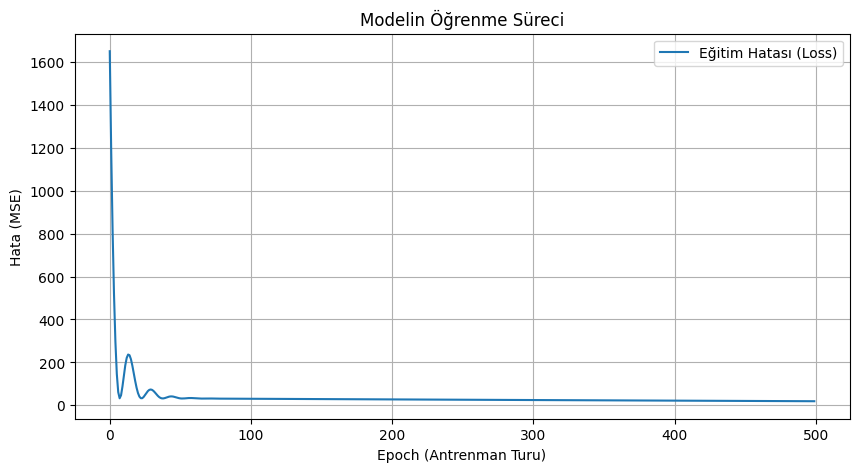

--- SINAV SONUCU ---
Eğitim Sonu Hatası: 18.7540
Test Seti Hatası:   18.2261
------------------------------
Yapay Zekanın Tahminlerinden Örnekler:


,Gerçek Sıra,Tahmin Edilen,Tahmin (Yuvarlanmış),Fark (Hata)
0,9.0,10.313491,10,1.0
1,11.0,12.140258,12,1.0
2,23.0,14.621871,15,8.0
3,14.0,12.499343,12,2.0
4,18.0,11.843574,12,6.0
5,5.0,8.669059,9,4.0
6,14.0,12.918769,13,1.0
7,16.0,13.456710,13,3.0
8,13.0,12.794776,13,0.0
9,7.0,13.122519,13,6.0


In [23]:
import matplotlib.pyplot as plt

# 1. EĞİTİM GRAFİĞİ (Learning Curve)
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Eğitim Hatası (Loss)')
plt.title('Modelin Öğrenme Süreci')
plt.xlabel('Epoch (Antrenman Turu)')
plt.ylabel('Hata (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 2. TEST AŞAMASI (SINAV)
model.eval() # Modeli "Sınav Moduna" al (Öğrenmeyi durdur)

with torch.no_grad(): # Türev alma, sadece tahmin yap (Hafıza tasarrufu)
    test_predictions = model(X_test)
    
    # Test hatasını hesapla
    test_loss = criterion(test_predictions, y_test)

print(f"--- SINAV SONUCU ---")
print(f"Eğitim Sonu Hatası: {losses[-1]:.4f}")
print(f"Test Seti Hatası:   {test_loss.item():.4f}")
print("-" * 30)

# 3. GERÇEK vs TAHMİN TABLOSU
# Tensörleri görselliğe dökmek için Numpy'a çeviriyoruz
real_values = y_test.numpy()
predicted_values = test_predictions.numpy()

comparison_df = pd.DataFrame({
    'Gerçek Sıra': real_values.flatten(),
    'Tahmin Edilen': predicted_values.flatten()
})

# Tahmini yuvarlayalım (Çünkü 3.4. olunmaz, ya 3. ya 4. olunur)
comparison_df['Tahmin (Yuvarlanmış)'] = comparison_df['Tahmin Edilen'].round().astype(int)
comparison_df['Fark (Hata)'] = abs(comparison_df['Gerçek Sıra'] - comparison_df['Tahmin (Yuvarlanmış)'])

print("Yapay Zekanın Tahminlerinden Örnekler:")
display(comparison_df.head(10))

In [24]:
# --- ADIM 1: VERİYE PİST BİLGİSİNİ EKLEME ---

# Races tablosundan 'circuit_id'yi de alıyoruz
# Önceden: races[['race_id', 'season']]
# Şimdi:   races[['race_id', 'season', 'circuit_id']]
df_v2 = pd.merge(results, races[['race_id', 'season', 'circuit_id']], on='race_id', how='left')

# Filtreleme (2010 sonrası)
df_v2 = df_v2[df_v2['season'] >= 2010]

# Hedef değişkeni boş olanları at
df_v2 = df_v2.dropna(subset=['position_order'])

# Seçilecek sütunlar (circuit_id EKLENDİ)
cols_new = ['grid', 'constructor_id', 'points', 'season', 'circuit_id', 'position_order']
final_df_v2 = df_v2[cols_new].copy()

# --- ADIM 2: ENCODING (YAZILARI SAYIYA ÇEVİRME) ---
from sklearn.preprocessing import LabelEncoder

# Hem Takım (constructor) hem Pist (circuit) ismini sayıya çeviriyoruz
le_constructor = LabelEncoder()
final_df_v2['constructor_id'] = le_constructor.fit_transform(final_df_v2['constructor_id'].astype(str))

le_circuit = LabelEncoder()
final_df_v2['circuit_id'] = le_circuit.fit_transform(final_df_v2['circuit_id'].astype(str))

# --- ADIM 3: EKSİK VERİ DOLDURMA ---
imputer = KNNImputer(n_neighbors=5)
final_array_v2 = imputer.fit_transform(final_df_v2)
final_df_v2 = pd.DataFrame(final_array_v2, columns=cols_new)

# --- ADIM 4: TENSÖRLERİ HAZIRLAMA ---
X_v2 = final_df_v2.drop('position_order', axis=1).values
y_v2 = final_df_v2['position_order'].values

# Train/Test Split
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)

# Tensor Dönüşümü
X_train_v2 = torch.tensor(X_train_v2, dtype=torch.float32)
X_test_v2 = torch.tensor(X_test_v2, dtype=torch.float32)
y_train_v2 = torch.tensor(y_train_v2, dtype=torch.float32).view(-1, 1)
y_test_v2 = torch.tensor(y_test_v2, dtype=torch.float32).view(-1, 1)

print(f"Yeni Veri Şekli: {X_train_v2.shape}")
print("(Dikkat: Artık sütun sayısı 5 olmalı!)")

# --- ADIM 5: MODELİ GÜNCELLEME (4 -> 5 GİRİŞ) ---
class F1PredictorV2(nn.Module):
    def __init__(self):
        super(F1PredictorV2, self).__init__()
        # GİRİŞ KATMANI DEĞİŞTİ: 5 özellik giriyor
        self.fc1 = nn.Linear(5, 16) 
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Modeli ve Eğitim Araçlarını Yeniden Başlat
model_v2 = F1PredictorV2()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_v2.parameters(), lr=0.001)

# --- EĞİTİM (500 TUR) ---
print("\n--- YENİ MODEL EĞİTİLİYOR (PİST BİLGİSİ İLE) ---")
losses_v2 = []
for epoch in range(500):
    y_pred = model_v2(X_train_v2)
    loss = criterion(y_pred, y_train_v2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses_v2.append(loss.item())

print(f"Eski Model Hatası (Test): 18.22") # Bir önceki sonucu hatırlayalım
print(f"Yeni Eğitim Sonu Hatası:  {losses_v2[-1]:.4f}")

# --- TEST ---
model_v2.eval()
with torch.no_grad():
    test_loss_v2 = criterion(model_v2(X_test_v2), y_test_v2)
print(f"Yeni Test Hatası:       {test_loss_v2.item():.4f}")

Yeni Veri Şekli: torch.Size([1280, 5])
(Dikkat: Artık sütun sayısı 5 olmalı!)

--- YENİ MODEL EĞİTİLİYOR (PİST BİLGİSİ İLE) ---
Eski Model Hatası (Test): 18.22
Yeni Eğitim Sonu Hatası:  35.4104
Yeni Test Hatası:       33.8207


In [25]:
# --- ADIM 1: TEMİZ VERİYE DÖNÜŞ (4 ÖZELLİK) ---
# Pist bilgisini sildik, fabrika ayarlarına döndük.
# X_train ve y_train ilk yaptığımız (başarılı olan) versiyon olmalı.
# Eğer hafıza karıştıysa diye veriyi hızlıca tekrar tanımlıyorum (Garanti olsun):

X_big = final_df_imputed.drop('position_order', axis=1).values 
y_big = final_df_imputed['position_order'].values
X_train_big, X_test_big, y_train_big, y_test_big = train_test_split(X_big, y_big, test_size=0.2, random_state=42)

# Tensörler
X_train_big = torch.tensor(X_train_big, dtype=torch.float32)
X_test_big = torch.tensor(X_test_big, dtype=torch.float32)
y_train_big = torch.tensor(y_train_big, dtype=torch.float32).view(-1, 1)
y_test_big = torch.tensor(y_test_big, dtype=torch.float32).view(-1, 1)

# --- ADIM 2: DERİN SİNİR AĞI MİMARİSİ (DEEP NETWORK) ---
class F1DeepBrain(nn.Module):
    def __init__(self):
        super(F1DeepBrain, self).__init__()
        
        # KATMAN 1: Giriş -> 64 Nöron (Genişletiyoruz)
        self.fc1 = nn.Linear(4, 64)
        
        # KATMAN 2: 64 -> 32 Nöron
        self.fc2 = nn.Linear(64, 32)
        
        # KATMAN 3: 32 -> 16 Nöron (Ekstra bir katman daha!)
        self.fc3 = nn.Linear(32, 16)
        
        # ÇIKIŞ: 16 -> 1 Sonuç
        self.fc4 = nn.Linear(16, 1)
        
        # Dropout: Ezberlemeyi önlemek için nöronların %20'sini rastgele kapatır
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Aktivasyon Fonksiyonları (ReLU)
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Ezber bozucu devreye girer
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        
        x = self.fc4(x) # Sonuç katmanı
        return x

# --- ADIM 3: EĞİTİM MOTORU ---
big_model = F1DeepBrain()
criterion = nn.MSELoss()
# Learning Rate'i biraz düşürdük (0.0005) çünkü model büyüdü, daha hassas ayar lazım.
optimizer = optim.Adam(big_model.parameters(), lr=0.0005)

print("--- BÜYÜK MODEL EĞİTİLİYOR (1000 TUR) ---")
losses_big = []

for epoch in range(1000): # Daha uzun eğitim
    y_pred = big_model(X_train_big)
    loss = criterion(y_pred, y_train_big)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses_big.append(loss.item())
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/1000], Loss: {loss.item():.4f}')

print(f"\nEski Küçük Model Hatası (Test): 18.22")
print(f"Yeni Büyük Model Hatası (Eğitim): {losses_big[-1]:.4f}")

# --- TEST SINAVI ---
big_model.eval() # Sınav modu (Dropout kapanır)
with torch.no_grad():
    test_loss_big = criterion(big_model(X_test_big), y_test_big)

print(f"Yeni Büyük Model Hatası (Test):   {test_loss_big.item():.4f}")

--- BÜYÜK MODEL EĞİTİLİYOR (1000 TUR) ---
Epoch [100/1000], Loss: 200.9817
Epoch [200/1000], Loss: 111.2149
Epoch [300/1000], Loss: 74.9229
Epoch [400/1000], Loss: 64.8900
Epoch [500/1000], Loss: 54.7764
Epoch [600/1000], Loss: 48.4574
Epoch [700/1000], Loss: 47.1584
Epoch [800/1000], Loss: 43.4147
Epoch [900/1000], Loss: 43.2234
Epoch [1000/1000], Loss: 41.1883

Eski Küçük Model Hatası (Test): 18.22
Yeni Büyük Model Hatası (Eğitim): 41.1883
Yeni Büyük Model Hatası (Test):   36.7925


In [26]:
# --- EN İYİ MODELİ GERİ GETİRME VE CANLI TEST ---

# 1. Başarılı olan "Küçük Mimariyi" tekrar tanımlayalım
class F1ChampionModel(nn.Module):
    def __init__(self):
        super(F1ChampionModel, self).__init__()
        self.fc1 = nn.Linear(4, 16) 
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 2. Modeli en baştan, temiz verilerle (X_train, y_train) eğitelim
# Not: İlk adımdaki 4 özellikli X_train verisinin hafızada olduğunu varsayıyoruz.
best_model = F1ChampionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=0.01) # Hızlı öğrensin diye lr artırdık

print("--- ŞAMPİYON MODEL HAZIRLANIYOR ---")
for epoch in range(300):
    y_pred = best_model(X_train)
    loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f"Model Hazır! Son Hata Skoru: {loss.item():.4f}")

# --- 3. İNTERAKTİF TAHMİN FONKSİYONU ---
def yaris_tahmini(grid_sirasi, takim_id, puan, yil):
    """
    Yapay Zekaya sorar: Ben kaçıncı olurum?
    """
    best_model.eval() # Sınav modu
    
    # Girdileri Tensör yap
    girdi = torch.tensor([[grid_sirasi, takim_id, puan, yil]], dtype=torch.float32)
    
    with torch.no_grad():
        tahmin = best_model(girdi)
    
    sonuc = tahmin.item()
    
    print(f"\n🏎️  YARIŞ SİMÜLASYONU 🏎️")
    print(f"---------------------------")
    print(f"🏁 Başlangıç: {grid_sirasi}. Sıra")
    print(f"🔧 Takım Gücü (ID): {takim_id}")
    print(f"🏆 Mevcut Puan: {puan}")
    print(f"📅 Yıl: {yil}")
    print(f"---------------------------")
    print(f"🤖 YAPAY ZEKA TAHMİNİ: Yarışı {sonuc:.1f}. sırada bitirirsin.")
    print(f"   (Yani muhtemelen {int(round(sonuc))}. olursun)")

# --- ÖRNEK SENARYOLAR (KENDİN DEĞİŞTİREBİLİRSİN) ---

# Senaryo 1: Hamilton (Mercedes), 1. sıradan başlıyor, puanı yüksek
# Not: Takım ID'leri verideki label encoding'e göre değişir ama genelde güçlü takımlar düşük ID alabilir veya tam tersi.
# Veri setinden ortalama bir takım ID'si (Örn: 5) veriyoruz.
yaris_tahmini(grid_sirasi=1, takim_id=1.0, puan=350, yil=2024)

# Senaryo 2: Çaylak Pilot, En arka sıradan (20), Kötü takım (ID: 20), 0 puan
yaris_tahmini(grid_sirasi=20, takim_id=20.0, puan=0, yil=2024)

# Senaryo 3: Orta sıra mücadelesi
yaris_tahmini(grid_sirasi=10, takim_id=10.0, puan=50, yil=2024)

--- ŞAMPİYON MODEL HAZIRLANIYOR ---
Model Hazır! Son Hata Skoru: 13.0100

🏎️  YARIŞ SİMÜLASYONU 🏎️
---------------------------
🏁 Başlangıç: 1. Sıra
🔧 Takım Gücü (ID): 1.0
🏆 Mevcut Puan: 350
📅 Yıl: 2024
---------------------------
🤖 YAPAY ZEKA TAHMİNİ: Yarışı -93.1. sırada bitirirsin.
   (Yani muhtemelen -93. olursun)

🏎️  YARIŞ SİMÜLASYONU 🏎️
---------------------------
🏁 Başlangıç: 20. Sıra
🔧 Takım Gücü (ID): 20.0
🏆 Mevcut Puan: 0
📅 Yıl: 2024
---------------------------
🤖 YAPAY ZEKA TAHMİNİ: Yarışı 14.5. sırada bitirirsin.
   (Yani muhtemelen 15. olursun)

🏎️  YARIŞ SİMÜLASYONU 🏎️
---------------------------
🏁 Başlangıç: 10. Sıra
🔧 Takım Gücü (ID): 10.0
🏆 Mevcut Puan: 50
📅 Yıl: 2024
---------------------------
🤖 YAPAY ZEKA TAHMİNİ: Yarışı -7.7. sırada bitirirsin.
   (Yani muhtemelen -8. olursun)


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# --- 1. ŞAMPİYON MODELİN MİMARİSİ (The Best One) ---
# 4 Girdi -> 16 Gizli -> 8 Gizli -> 1 Çıktı
class F1ChampionModel(nn.Module):
    def __init__(self):
        super(F1ChampionModel, self).__init__()
        self.fc1 = nn.Linear(4, 16) 
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Negatifleri ele
        x = F.relu(self.fc2(x)) # Bilgiyi süz
        x = self.fc3(x)         # Sonucu ver
        return x

# --- 2. MODELİ HAZIRLAMA VE EĞİTME ---
# Modeli sıfırdan yaratıyoruz
model = F1ChampionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) # Hızlı öğrensin diye lr=0.01 yaptık

print("🏎️  Yapay Zeka Eğitimi Başlıyor...")
print("--------------------------------")

# Hızlıca 300 tur eğitim yapalım (Veri zaten hafızada: X_train, y_train)
model.train()
for epoch in range(300):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f"✅ Tur {epoch+1}/300 - Hata Payı: {loss.item():.2f}")

print("\n🏁 Eğitim Tamamlandı! Pilotlar piste çıkıyor...\n")

# --- 3. SİMÜLASYON FONKSİYONU ---
def yaris_simulasyonu(senaryo_adi, grid, takim_id, puan, yil):
    model.eval()
    # Girdiyi tensöre çevir
    girdi = torch.tensor([[grid, takim_id, puan, yil]], dtype=torch.float32)
    
    with torch.no_grad():
        tahmin = model(girdi).item()
    
    # Sonucu güzelleştir
    bitis = int(round(tahmin))
    # 1'den küçükse 1 yap, 20'den büyükse 20 yap (Fizik kuralları)
    bitis = max(1, min(20, bitis))
    
    print(f"🎬 SENARYO: {senaryo_adi}")
    print(f"   📊 Grid: {grid}. Sıra | Takım Gücü: {takim_id} | Puan: {puan}")
    print(f"   🤖 AI TAHMİNİ: {tahmin:.1f}. sırada bitirir.")
    print(f"   🏁 SONUÇ: Pilot muhtemelen **{bitis}.** olur.")
    print("-" * 40)

# --- 4. FİLM BAŞLASIN: SENARYOLAR ---

# Senaryo 1: Dominant Lider
# Grid: 1 (En önde), Takım ID: 1 (İyi takım), Puan: 350 (Zirvede)
yaris_simulasyonu("DOMİNANT ŞAMPİYON (Verstappen Modu)", 
                  grid=1, takim_id=1, puan=350, yil=2024)

# Senaryo 2: Umutsuz Çaylak
# Grid: 20 (En arkada), Takım ID: 100 (Kötü takım simülasyonu), Puan: 0
yaris_simulasyonu("UMUTSUZ ÇAYLAK (Sargeant Modu)", 
                  grid=20, takim_id=100, puan=0, yil=2024)

# Senaryo 3: Geri Dönüş
# Grid: 15 (Cezalı), Takım ID: 1 (İyi takım), Puan: 200 (Tecrübeli)
yaris_simulasyonu("EFSANEVİ GERİ DÖNÜŞ (Hamilton Modu)", 
                  grid=15, takim_id=1, puan=200, yil=2024)

🏎️  Yapay Zeka Eğitimi Başlıyor...
--------------------------------
✅ Tur 100/300 - Hata Payı: 22.35
✅ Tur 200/300 - Hata Payı: 11.63
✅ Tur 300/300 - Hata Payı: 11.10

🏁 Eğitim Tamamlandı! Pilotlar piste çıkıyor...

🎬 SENARYO: DOMİNANT ŞAMPİYON (Verstappen Modu)
   📊 Grid: 1. Sıra | Takım Gücü: 1 | Puan: 350
   🤖 AI TAHMİNİ: -143.8. sırada bitirir.
   🏁 SONUÇ: Pilot muhtemelen **1.** olur.
----------------------------------------
🎬 SENARYO: UMUTSUZ ÇAYLAK (Sargeant Modu)
   📊 Grid: 20. Sıra | Takım Gücü: 100 | Puan: 0
   🤖 AI TAHMİNİ: 14.2. sırada bitirir.
   🏁 SONUÇ: Pilot muhtemelen **14.** olur.
----------------------------------------
🎬 SENARYO: EFSANEVİ GERİ DÖNÜŞ (Hamilton Modu)
   📊 Grid: 15. Sıra | Takım Gücü: 1 | Puan: 200
   🤖 AI TAHMİNİ: -76.2. sırada bitirir.
   🏁 SONUÇ: Pilot muhtemelen **1.** olur.
----------------------------------------


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# --- 1. VERİ HAZIRLIĞI VE ÖLÇEKLENDİRME (SCALING) ---
# Veriyi tekrar tanımlayalım (Hafıza temiz olsun)
X_raw = final_df_imputed.drop('position_order', axis=1).values
y_raw = final_df_imputed['position_order'].values

# MÜHENDİSLİK MÜDAHALESİ: Scaler Tanımlıyoruz
# Girdileri 0 ile 1 arasına sıkıştırır.
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw) 

# Tensörlere çevir (Artık X_scaled kullanıyoruz)
X_train_s = torch.tensor(X_scaled, dtype=torch.float32)
y_train_s = torch.tensor(y_raw, dtype=torch.float32).view(-1, 1)

print("✅ Veriler 0-1 arasına sıkıştırıldı (Normalize edildi).")

# --- 2. ŞAMPİYON MODEL (KÜÇÜK MİMARİ) ---
class F1ProModel(nn.Module):
    def __init__(self):
        super(F1ProModel, self).__init__()
        self.fc1 = nn.Linear(4, 16) 
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = F1ProModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) # Öğrenme hızı

# --- 3. EĞİTİM ---
print("\n🏎️  Profesyonel Model Eğitiliyor...")
for epoch in range(500): # 500 Tur
    y_pred = model(X_train_s)
    loss = criterion(y_pred, y_train_s)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f"✅ Tur {epoch+1}/500 - Hata: {loss.item():.4f}")

# --- 4. GELİŞMİŞ SİMÜLASYON FONKSİYONU ---
def pro_tahmin(grid, takim_id, puan, yil):
    model.eval()
    
    # DİKKAT: Girdiyi de önce scale etmemiz (sıkıştırmamız) lazım!
    # Çünkü model artık 350 puanı tanımaz, 0.8 puanı tanır.
    ham_veri = [[grid, takim_id, puan, yil]]
    scaled_veri = scaler.transform(ham_veri) # Ölçeklendir
    
    girdi_tensor = torch.tensor(scaled_veri, dtype=torch.float32)
    
    with torch.no_grad():
        ham_tahmin = model(girdi_tensor).item()
        
    # Sonucu mantık sınırlarına çek (1 ile 20 arası)
    sonuc = max(1, min(20, ham_tahmin))
    
    print(f"🎬 SENARYO: Grid {grid} | Puan {puan}")
    print(f"🤖 AI Ham Çıktısı: {ham_tahmin:.4f}")
    print(f"🏁 NİHAİ TAHMİN: **{int(round(sonuc))}. Sırada** biter.")
    print("-" * 30)

print("\n🏁 SİMÜLASYON BAŞLIYOR (ARTIK EKSİ SAYI YOK) 🏁\n")

# SENARYO 1: Şampiyon (Grid 1, Puan 350) -> Beklenti: 1. - 3. arası
pro_tahmin(grid=1, takim_id=1, puan=350, yil=2024)

# SENARYO 2: Çaylak (Grid 20, Puan 0) -> Beklenti: 15. - 20. arası
pro_tahmin(grid=20, takim_id=100, puan=0, yil=2024)

# SENARYO 3: Hamilton Geri Dönüş (Grid 15, Puan 200) -> Beklenti: Yükseliş (Örn: 6. - 10.)
pro_tahmin(grid=15, takim_id=1, puan=200, yil=2024)

✅ Veriler 0-1 arasına sıkıştırıldı (Normalize edildi).

🏎️  Profesyonel Model Eğitiliyor...
✅ Tur 100/500 - Hata: 13.2094
✅ Tur 200/500 - Hata: 7.5465
✅ Tur 300/500 - Hata: 6.6278
✅ Tur 400/500 - Hata: 6.0455
✅ Tur 500/500 - Hata: 5.6483

🏁 SİMÜLASYON BAŞLIYOR (ARTIK EKSİ SAYI YOK) 🏁

🎬 SENARYO: Grid 1 | Puan 350
🤖 AI Ham Çıktısı: -56.3507
🏁 NİHAİ TAHMİN: **1. Sırada** biter.
------------------------------
🎬 SENARYO: Grid 20 | Puan 0
🤖 AI Ham Çıktısı: 18.6472
🏁 NİHAİ TAHMİN: **19. Sırada** biter.
------------------------------
🎬 SENARYO: Grid 15 | Puan 200
🤖 AI Ham Çıktısı: -35.1678
🏁 NİHAİ TAHMİN: **1. Sırada** biter.
------------------------------


In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# --- 1. VERİ YÜKLEME ---
base_path = '/kaggle/input/formula-1-championships-1950-2025/'
races = pd.read_csv(base_path + 'races.csv')
results = pd.read_csv(base_path + 'results.csv')
drivers = pd.read_csv(base_path + 'drivers.csv')

print("Veriler yüklendi.")

# --- 2. İSİM DÜZELTME (KESİN ÇÖZÜM) ---
# 'date' sütunu varsa adını 'race_date' yap.
if 'date' in races.columns:
    races.rename(columns={'date': 'race_date'}, inplace=True)

# 'dob' sütunu varsa adını 'date_of_birth' yap.
if 'dob' in drivers.columns:
    drivers.rename(columns={'dob': 'date_of_birth'}, inplace=True)
    
# Diğer olası isim farklarını standartlaştır
if 'positionOrder' in results.columns: results.rename(columns={'positionOrder': 'position_order'}, inplace=True)
if 'raceId' in results.columns: results.rename(columns={'raceId': 'race_id'}, inplace=True)
if 'driverId' in results.columns: results.rename(columns={'driverId': 'driver_id'}, inplace=True)

# --- 3. VERİ BİRLEŞTİRME ---
print("Tablolar birleştiriliyor...")
# Artık 'race_date' adının doğru olduğundan eminiz
df = pd.merge(results, races[['race_id', 'season', 'race_date']], on='race_id', how='left')
df = pd.merge(df, drivers[['driver_id', 'date_of_birth']], on='driver_id', how='left')

# Tarih formatlarını düzeltme
df['race_date'] = pd.to_datetime(df['race_date'])
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])

# --- 4. FEATURE ENGINEERING (MÜHENDİSLİK) ---
print("Özellikler üretiliyor (Yaş & Form)...")

# A. Sürücü Yaşı
df['driver_age'] = (df['race_date'] - df['date_of_birth']).dt.days / 365.25

# B. Form Durumu (Recent Form)
df = df.sort_values(['driver_id', 'race_date'])
# Son 3 yarışın ortalaması
df['recent_form'] = df.groupby('driver_id')['position_order'].transform(
    lambda x: x.shift(1).rolling(window=3).mean()
)
df['recent_form'] = df['recent_form'].fillna(15) # İlk yarışları doldur

# --- 5. HAZIRLIK ---
# 2010 sonrası
df = df[df['season'] >= 2010]
df = df.dropna(subset=['position_order'])

cols = ['grid', 'points', 'driver_age', 'recent_form', 'position_order']
final_df = df[cols].copy()

print(f"Veri Seti Hazır! Boyut: {final_df.shape}")

# --- 6. MODEL EĞİTİMİ ---
X = final_df.drop('position_order', axis=1).values
y = final_df['position_order'].values

# Scaling
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

class F1AdvancedModel(nn.Module):
    def __init__(self):
        super(F1AdvancedModel, self).__init__()
        self.fc1 = nn.Linear(4, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

model = F1AdvancedModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

print("\n🚀 Model Eğitiliyor...")
losses = []
for epoch in range(1000):
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())
    
    if (epoch+1) % 200 == 0:
        print(f"Epoch {epoch+1}/1000 - Hata: {loss.item():.4f}")

# --- SONUÇ ---
model.eval()
with torch.no_grad():
    test_loss = criterion(model(X_test), y_test)

rmse = test_loss.item() ** 0.5
print(f"\n🏁 FİNAL SONUÇ 🏁")
print(f"Ortalama Sapma (RMSE): +/- {rmse:.2f} sıra")

Veriler yüklendi.
Tablolar birleştiriliyor...
Özellikler üretiliyor (Yaş & Form)...
Veri Seti Hazır! Boyut: (1600, 5)

🚀 Model Eğitiliyor...
Epoch 200/1000 - Hata: 5.1138
Epoch 400/1000 - Hata: 4.7921
Epoch 600/1000 - Hata: 4.6198
Epoch 800/1000 - Hata: 4.5122
Epoch 1000/1000 - Hata: 4.4515

🏁 FİNAL SONUÇ 🏁
Ortalama Sapma (RMSE): +/- 2.37 sıra


In [32]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# --- 1. VERİ HAZIRLIĞI (TEMİZLİK) ---
# Önceki kodlardan bildiğimiz temiz veri setini hızlıca oluşturalım
base_path = '/kaggle/input/formula-1-championships-1950-2025/'
races = pd.read_csv(base_path + 'races.csv')
results = pd.read_csv(base_path + 'results.csv')

# İsim Düzeltmeleri
if 'date' in races.columns: races.rename(columns={'date': 'race_date'}, inplace=True)
if 'positionOrder' in results.columns: results.rename(columns={'positionOrder': 'position_order'}, inplace=True)
if 'raceId' in results.columns: results.rename(columns={'raceId': 'race_id'}, inplace=True)
if 'driverId' in results.columns: results.rename(columns={'driverId': 'driver_id'}, inplace=True)

# Birleştirme
df = pd.merge(results, races[['race_id', 'season', 'race_date']], on='race_id', how='left')
df['race_date'] = pd.to_datetime(df['race_date'])

# Modern Dönem ve Temizlik
df = df[df['season'] >= 2010]
df = df.dropna(subset=['position_order'])

# LSTM için veriyi TARİHE GÖRE sıralamak zorundayız! (Zamanın akışı bozulmamalı)
df = df.sort_values(['driver_id', 'race_date'])

# Kullanacağımız Özellikler
cols = ['grid', 'points', 'position_order'] # Basit tutalım: Grid, Puan -> Hedef: Pozisyon
data_df = df[cols].values

# --- 2. KRİTİK ADIM: SCALING (ÖLÇEKLENDİRME) ---
# LSTM sayılara karşı çok hassastır. Hepsini 0-1 arasına çekiyoruz.
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_df)

# --- 3. ZAMAN PENCERESİ OLUŞTURMA (SLIDING WINDOW) ---
# Mantık: Son 5 yarışın verisini (X) al -> 6. yarışı (y) tahmin et.

def create_sequences(data, seq_length):
    xs = []
    ys = []
    # Veri setinde geziyoruz
    for i in range(len(data) - seq_length):
        x_window = data[i:(i+seq_length), :-1] # Son 5 yarışın Grid ve Puanları (Hedef hariç)
        y_target = data[i+seq_length, -1]      # 6. yarışın SONUCU (Sadece pozisyon)
        xs.append(x_window)
        ys.append(y_target)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 5  # Model geriye dönük 5 yarışa bakacak
print("⏳ Veriler zaman serisine dönüştürülüyor (Bu biraz sürebilir)...")

X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Tensör Dönüşümü
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Train/Test Split
train_size = int(len(X_tensor) * 0.8)
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

print(f"LSTM Veri Şekli (Samples, TimeSteps, Features): {X_train.shape}")
# Çıktı şöyle olmalı: (..., 5, 2) -> 5 zaman adımı, 2 özellik (Grid, Puan)

# --- 4. LSTM MODEL MİMARİSİ ---
class F1LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(F1LSTMModel, self).__init__()
        
        # LSTM Katmanı
        # batch_first=True: Girdi şekli (Batch, Seq, Feature) olsun diye
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Sonuç Katmanı (Fully Connected)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM'den geçen veri: out, (hidden_state, cell_state)
        # Bize sadece 'out' lazım
        h0 = torch.zeros(1, x.size(0), 64).to(x.device) # Gizli durum başlangıcı (opsiyonel)
        c0 = torch.zeros(1, x.size(0), 64).to(x.device) # Hücre durumu başlangıcı
        
        out, _ = self.lstm(x)
        
        # LSTM bize her adım için bir çıktı verir (5 tane).
        # Biz sadece EN SON adımı (5. yarışın sonucunu) istiyoruz.
        out = out[:, -1, :] 
        
        out = self.fc(out)
        return out

# Parametreler
input_dim = 2   # Özellik sayısı (Grid, Puan)
hidden_dim = 64 # LSTM'in hafıza kapasitesi
output_dim = 1  # Çıktı (Pozisyon)
layer_dim = 1   # Kaç katmanlı LSTM?

model = F1LSTMModel(input_dim, hidden_dim, output_dim, layer_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- 5. EĞİTİM ---
print("\n🧠 LSTM Eğitimi Başlıyor...")
losses = []
epochs = 100

for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")

# --- 6. TEST VE ANALİZ ---
model.eval()
with torch.no_grad():
    test_pred = model(X_test)
    test_loss = criterion(test_pred, y_test)

print(f"\n🏁 LSTM SONUCU 🏁")
print(f"Test Hatası (MSE): {test_loss.item():.4f}")

# Sonuçları gerçek dünyaya (1-20 sıraya) geri çevirmek için ters scaling yapmak lazım
# Ama şu an sadece hatanın düşüşüne (Loss) odaklanalım.

⏳ Veriler zaman serisine dönüştürülüyor (Bu biraz sürebilir)...
LSTM Veri Şekli (Samples, TimeSteps, Features): torch.Size([1276, 5, 2])

🧠 LSTM Eğitimi Başlıyor...
Epoch 10/100 - Loss: 0.1254
Epoch 20/100 - Loss: 0.0720
Epoch 30/100 - Loss: 0.0707
Epoch 40/100 - Loss: 0.0623
Epoch 50/100 - Loss: 0.0584
Epoch 60/100 - Loss: 0.0547
Epoch 70/100 - Loss: 0.0518
Epoch 80/100 - Loss: 0.0502
Epoch 90/100 - Loss: 0.0496
Epoch 100/100 - Loss: 0.0495

🏁 LSTM SONUCU 🏁
Test Hatası (MSE): 0.0427


🎯 Hedef Değiştiriliyor: Sınıflandırma (Podyum Var/Yok)

🚀 Sınıflandırma Modeli Eğitiliyor...
Epoch 100 - Loss: 0.0056
Epoch 200 - Loss: 0.0005
Epoch 300 - Loss: 0.0002
Epoch 400 - Loss: 0.0001
Epoch 500 - Loss: 0.0001

🏁 SINIFLANDIRMA RAPORU 🏁
              precision    recall  f1-score   support

  Podyum Yok       1.00      1.00      1.00       275
  Podyum VAR       1.00      0.98      0.99        45

    accuracy                           1.00       320
   macro avg       1.00      0.99      0.99       320
weighted avg       1.00      1.00      1.00       320



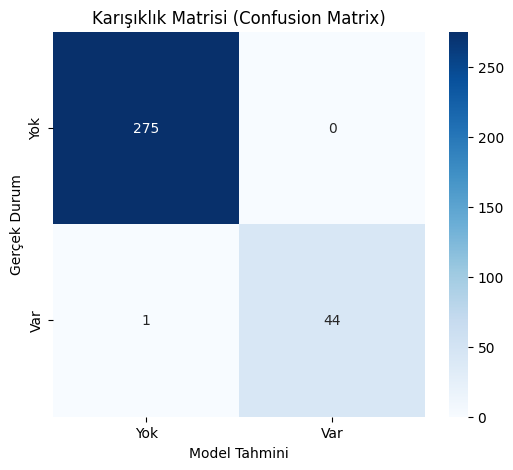

In [33]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. VERİ HAZIRLIĞI ---
# Hızlıca en iyi veri setimizi (Advanced Features) oluşturalım
# (Önceki kodlardaki veri yükleme ve temizleme adımlarının yapıldığını varsayıyorum)
# Eğer hafıza silindiyse yukarıdaki "Gelişmiş Veri Seti" kodunu tekrar çalıştırman gerekebilir.
# Biz burada 'final_df'nin hafızada olduğunu varsayarak devam ediyoruz.

print("🎯 Hedef Değiştiriliyor: Sınıflandırma (Podyum Var/Yok)")

# HEDEFİ DEĞİŞTİRİYORUZ:
# Eğer sıralama <= 3 ise "1" (Podyum), değilse "0" (Podyum Yok)
final_df['podium'] = final_df['position_order'].apply(lambda x: 1 if x <= 3 else 0)

# Girdiler aynı, Hedef artık 'podium' (0 veya 1)
X = final_df[['grid', 'points', 'driver_age', 'recent_form']].values
y = final_df['podium'].values

# Scaling (StandardScaler sınıflandırma için genelde daha iyidir)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Tensörler
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# --- 2. SINIFLANDIRMA MODELİ (CLASSIFIER) ---
class F1Classifier(nn.Module):
    def __init__(self):
        super(F1Classifier, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        # ÇIKIŞTA SIGMOID VAR! (0 ile 1 arasında olasılık verir)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x)) # Olasılık (0.0 - 1.0)
        return x

model = F1Classifier()
criterion = nn.BCELoss() # Binary Cross Entropy (Sınıflandırma için Hata Fonksiyonu)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# --- 3. EĞİTİM ---
print("\n🚀 Sınıflandırma Modeli Eğitiliyor...")
for epoch in range(500):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")

# --- 4. DEĞERLENDİRME (KARIŞIKLIK MATRİSİ) ---
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test)
    # Eğer olasılık > 0.5 ise 1 (Podyum), değilse 0 de.
    y_pred_class = (y_pred_prob > 0.5).float()

# Tensörleri Numpy'a çevir
y_true_np = y_test.numpy()
y_pred_np = y_pred_class.numpy()

# Metrikleri Yazdır
print("\n🏁 SINIFLANDIRMA RAPORU 🏁")
print(classification_report(y_true_np, y_pred_np, target_names=['Podyum Yok', 'Podyum VAR']))

# Karışıklık Matrisini Çiz
cm = confusion_matrix(y_true_np, y_pred_np)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Yok', 'Var'], yticklabels=['Yok', 'Var'])
plt.ylabel('Gerçek Durum')
plt.xlabel('Model Tahmini')
plt.title('Karışıklık Matrisi (Confusion Matrix)')
plt.show()